In [1]:
# implmenting STA/LTA algorithm to detect seismic events
# author: Kaushik Pradhan (kpradhan@miners.utep.edu)
# date: 02/26/2024

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

from obspy.clients.fdsn.client import Client
from obspy.core.utcdatetime import UTCDateTime

In [3]:
# this station was installed on March 2020, so looking for big earthquake in the region after that
# read the csv file from a link - magnitude Mw 6.5+ earthquakes after 2020-03-05T22:00:00 to today

usgs_url = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=2020-03-05%2022:00:00&endtime=2024-02-20%2023:59:59&minmagnitude=6.5&orderby=time'
usgs_data = pd.read_csv(usgs_url)

URLError: <urlopen error [Errno 61] Connection refused>

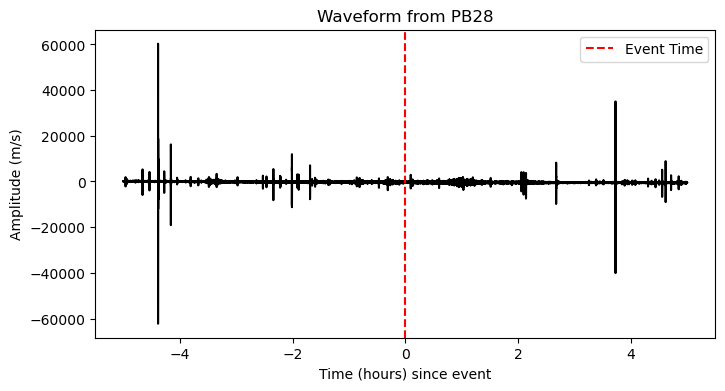

In [ ]:
client = Client('texnet')

eq_time = UTCDateTime(usgs_data.iloc[20]['time'])
starttime = eq_time - 5 * 3600 # 5 hours before the event
endtime = eq_time + 5 * 3600

stream = client.get_waveforms('TX', 'PB28', '00', 'HHZ', starttime, endtime)

data = stream[0].data

# Create a time array for the waveform
sampling_rate = stream[0].stats.sampling_rate
num_samples = len(data)
times_seconds = [(starttime + i / sampling_rate) - eq_time for i in range(num_samples)]  # Time array in seconds
times_hours = [t / 3600 for t in times_seconds]  # Convert seconds to hours

plt.figure(figsize=(8, 4))
plt.plot(times_hours, data, 'k')  
plt.title('Waveform from PB28')
plt.xlabel('Time (hours) since event')
plt.ylabel('Amplitude (m/s)')
plt.axvline(x=0, color='r', linestyle='--', label='Event Time')  
plt.legend()
plt.show()

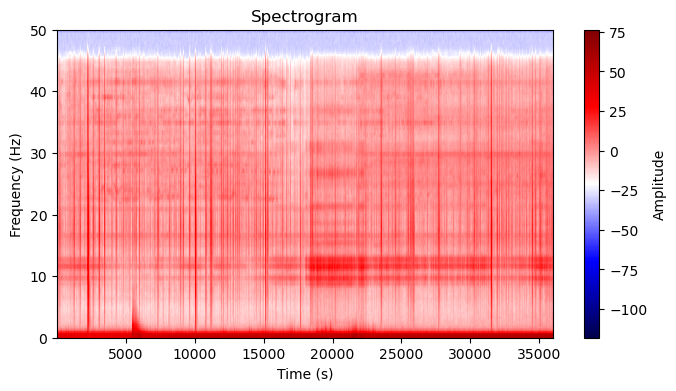

In [ ]:
plt.figure(figsize=(8, 4))
plt.specgram(data, Fs=sampling_rate, NFFT=256, noverlap=128, cmap='seismic')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

In [ ]:
cnt = 0  # initialize earthquake count
individual_hv = {}  # initialize dictionary to store earthquake indices
seismic_data = data_1d
window_size = 3600  # Define the size of the window in number of samples (adjust as needed)
sampling_rate = 1  # Define the sampling rate of the data (adjust as needed)

for window_start in range(0, len(seismic_data), window_size):
    window_end = min(window_start + window_size, len(seismic_data))
    window_data = seismic_data[window_start:window_end]

    for subtrace_z in window_data:  # Iterate over each seismic trace in the window
        threshold = 10.0
        long_term_avg = np.mean(np.abs(subtrace_z))

        sta_lta = []
        vec2 = np.arange(0, len(subtrace_z), 60 * sampling_rate)
        for p in range(len(vec2) - 1):
            short_term_avg = np.mean(np.abs(subtrace_z[vec2[p]:vec2[p + 1]]))
            ratio_avgs = short_term_avg / long_term_avg
            sta_lta.append(ratio_avgs)

        max_ratio_avg = max(sta_lta)
        if max_ratio_avg > threshold:
            cnt += 1
            # Record the earthquake index relative to the beginning of the window
            index_in_window = np.where(window_data == subtrace_z)[0][0]
            individual_hv[window_start + index_in_window] = np.nan * np.zeros(len(subtrace_z))

print("Number of earthquakes:", cnt)


TypeError: object of type 'numpy.int32' has no len()